In [3]:
from google.colab import files
files.upload()  # this lets you select and upload the kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle


Saving kaggle.json to kaggle (1).json


In [4]:
!kaggle datasets download -d pypiahmad/realistic-action-recognition-ucf50


Dataset URL: https://www.kaggle.com/datasets/pypiahmad/realistic-action-recognition-ucf50
License(s): Attribution 4.0 International (CC BY 4.0)
realistic-action-recognition-ucf50.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip realistic-action-recognition-ucf50.zip


Archive:  realistic-action-recognition-ucf50.zip
replace UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,LSTM,Dropout,TimeDistributed
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [10]:
classes=["Basketball",
          "Biking",
          "Diving",
          "Drumming",
        "Fencing",
        "HighJump",
        "Mixing",
        "Punch",
        "YoYo"]

data_set_path=r"/content/UCF50"

for cls in classes:
    print(f"{cls}->total videos",len(os.listdir(os.path.join(data_set_path,cls))))




Basketball->total videos 137
Biking->total videos 145
Diving->total videos 153
Drumming->total videos 161
Fencing->total videos 111
HighJump->total videos 123
Mixing->total videos 141
Punch->total videos 160
YoYo->total videos 128


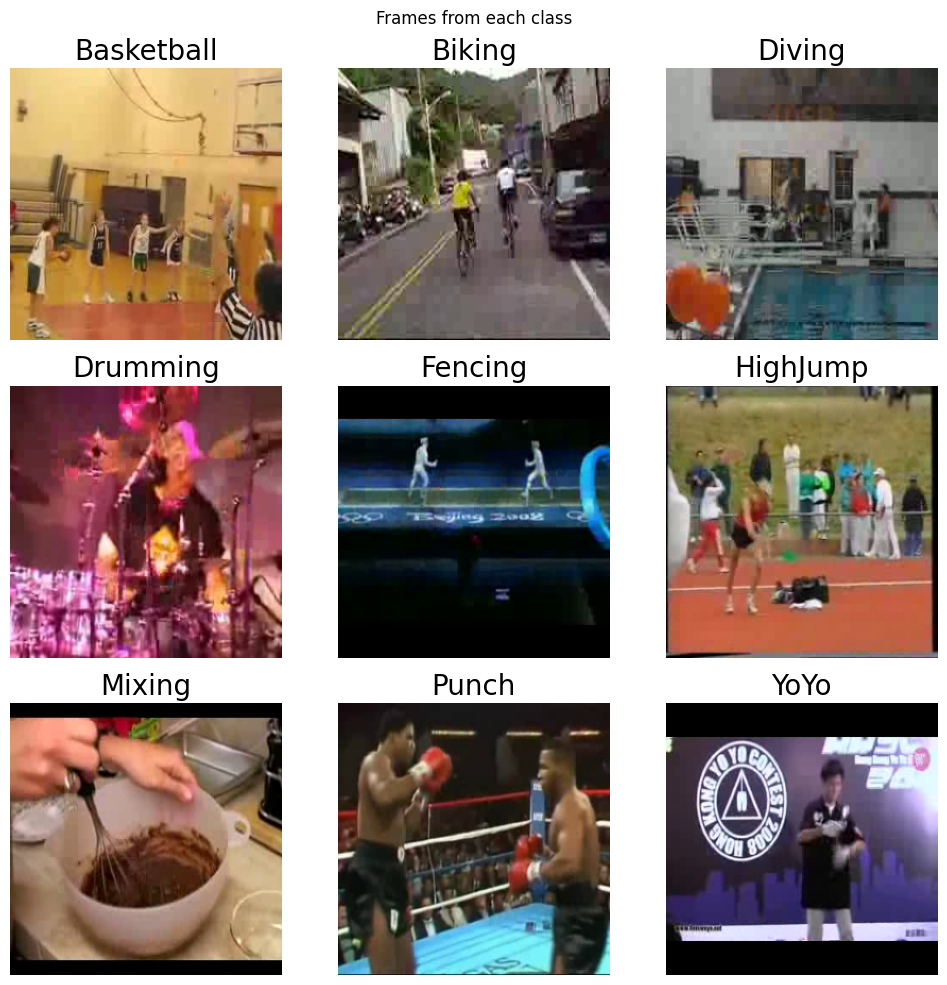

In [11]:
def show_frames(classes,data_set_path):
    fig,axes=plt.subplots(3,3,figsize=(10,10))
    axes=axes.flatten()
    for i,cls in enumerate(classes):
      video_path=os.path.join(data_set_path,cls,os.listdir(os.path.join(data_set_path,cls))[0])
      cap=cv2.VideoCapture(video_path)
      ret ,frame=cap.read()
      cap.release()
      if ret:
        frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frame=cv2.resize(frame,(256,256))
        axes[i].imshow(frame)
        axes[i].set_title(cls,fontsize=20)
      axes[i].axis("off")
    plt.suptitle("Frames from each class")
    plt.tight_layout()
    plt.show()



show_frames(classes,data_set_path)






In [12]:
def extract_frames(video,num_frames=20):
  cap=cv2.VideoCapture(video)
  ret,frame=cap.read()
  total_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  require_frames=max(total_frames//num_frames,1)
  count=0
  X=[]
  while len(X)<num_frames and cap.isOpened():
    if not ret:
      break
    if count % num_frames==0:
       frame=cv2.resize(frame,(64,64))
       frame=frame/255.0
       X.append(frame)
  count=count+1
  cap.release()

  while len(X)<num_frames:
    X.apppen(frames[-1])

  return np.array(X)



In [13]:
X=[]
y=[]
num_frames=20
for i,cls in enumerate(classes):
  classes_path=os.path.join(data_set_path,cls)
  videos_folder=os.listdir(classes_path)
  for video_path in videos_folder:
    video=os.path.join(classes_path,video_path)
    frames=extract_frames(video,num_frames)
    if frames.shape==(20,64,64,3):
      X.append(frames)
      y.append(i)


X=np.array(X)
y=to_categorical(y)

print(X.shape)
print(y.shape)





(1259, 20, 64, 64, 3)
(1259, 9)


In [14]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

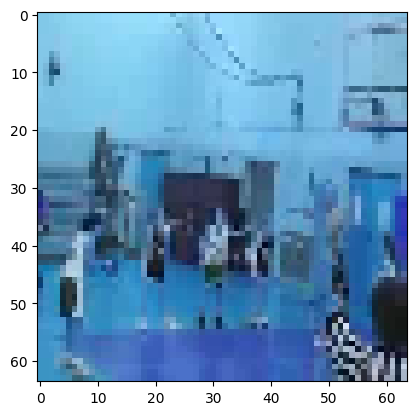

In [15]:
plt.imshow(X[0][0])

In [16]:
early_stop = EarlyStopping(
    monitor='val_loss',      # what metric to watch
    patience=5,              # wait for 5 epochs without improvement
    restore_best_weights=True # load best model at end
)

In [17]:
model=Sequential()

model.add(TimeDistributed(Conv2D(32,(3,3),activation="relu"),input_shape=(20,64,64,3)))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Conv2D(64,(3,3),activation="relu")))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.25)))

model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dropout(0.5)))

model.add(LSTM(64,dropout=0.3,recurrent_dropout=0.3))
model.add(Dense(9,activation="softmax"))
model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# In CNN use dropout to prevent overfiiting inside CNN
# Prevent LSTM from overfitting to giant feature vectors ,becuase we dont gave huge vector to the LSTM

# In LSTM Prevent memorizing sequences
# (dropout=0.3) prevent the model from memorizing specific features from the frames.
# (recurrent_dropout=0.3) prevents the LSTM from memorizing the exact sequence pattern.

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 62, 62, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 31, 31, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 29, 29, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 12544)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 12544)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     3,227,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,247,881 (12.39 MB)

 Trainable params: 3,247,881 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history=model.fit(x_train, y_train, epochs=12, validation_data=(x_test, y_test),callbacks=[early_stop])


Epoch 1/12
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 410ms/step - accuracy: 0.1016 - loss: 2.1973 - val_accuracy: 0.1270 - val_loss: 2.1826
Epoch 2/12
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 331ms/step - accuracy: 0.1870 - loss: 2.1452 - val_accuracy: 0.3095 - val_loss: 1.9640
Epoch 3/12
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - accuracy: 0.2526 - loss: 1.9547 - val_accuracy: 0.3492 - val_loss: 1.7960
Epoch 4/12
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.3418 - loss: 1.7927 - val_accuracy: 0.3452 - val_loss: 1.8534
Epoch 5/12
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 340ms/step - accuracy: 0.4041 - loss: 1.6677 - val_accuracy: 0.4087 - val_loss: 1.5466
Epoch 6/12
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.4378 - loss: 1.4728 - val_accuracy: 0.4762 - val_loss: 1.5841
Epoch 7/12
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - accuracy: 0.4631 - loss: 1.4501 - val_accuracy: 0.5079 - val_loss: 1.4362
Epoch 8/12
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.5167 - loss: 1.4170 - val_accu

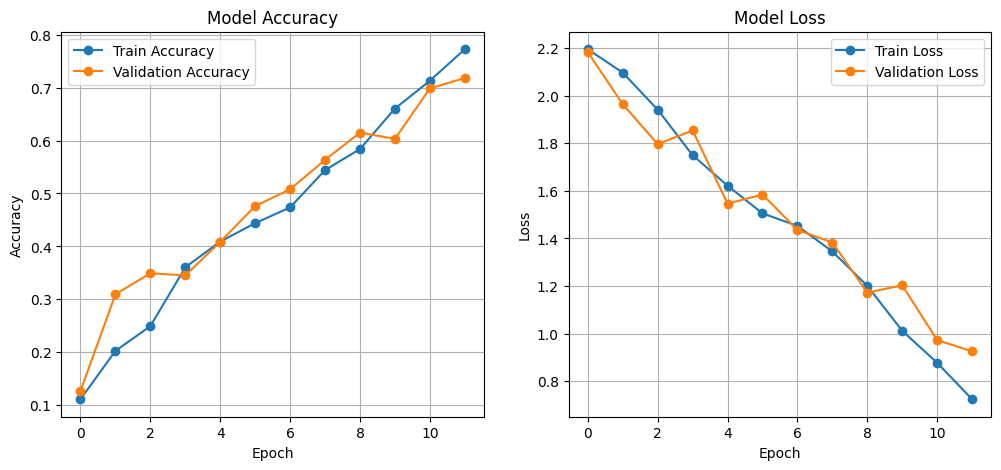

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

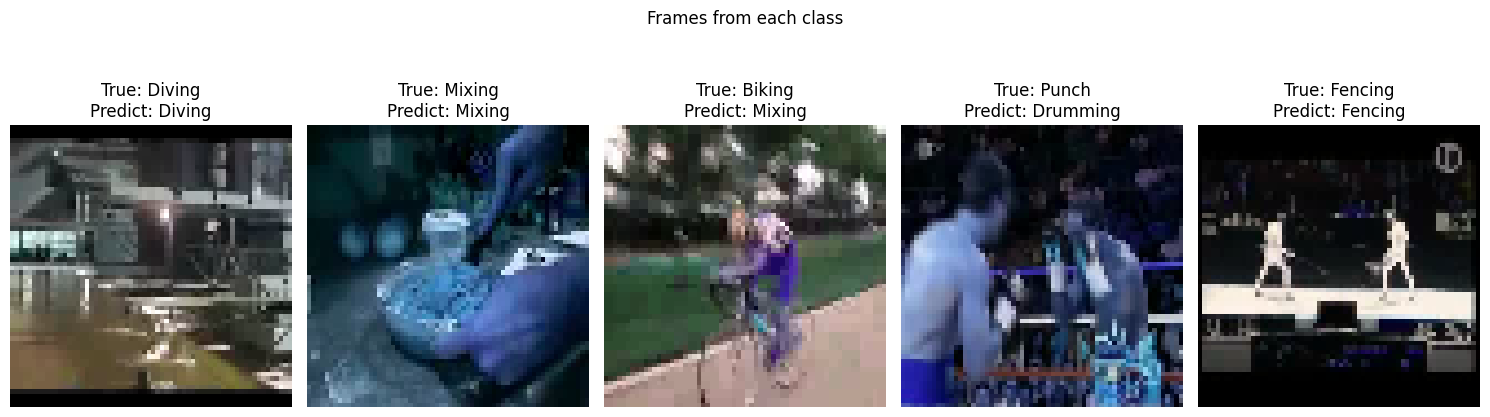

In [22]:


def show_prediction(model, x_test, y_test, classes):
    indexes = np.random.choice(len(x_test), 5, replace=False)
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))

    for i, idx in enumerate(indexes):
        video = x_test[idx]
        true_label = classes[np.argmax(y_test[idx])]


        predicted = model.predict(np.expand_dims(video, axis=0), verbose=0)
        predicted_label = classes[np.argmax(predicted)]

        # Take middle frame
        # mid_frame = video[len(video)//2]
        start=video[0]
        frame = (start * 255).astype(np.uint8)

        axes[i].imshow(frame)
        axes[i].set_title(f"True: {true_label}\nPredict: {predicted_label}")  # newline
        axes[i].axis("off")

    plt.suptitle("Frames from each class")
    plt.tight_layout()
    plt.show()

# Usage
show_prediction(model, x_test, y_test, classes)
